In [61]:
# YOUR CODE HERE
import numpy as np

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, accuracy_score

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture

## Used to save data into files
import pickle as pkl
import os

## Importing dataset

In [2]:
## Import train and test dataset and convert them to data loaders

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = len(train_dataset),
                          shuffle = False)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = len(test_dataset),
                          shuffle = False)

In [3]:
# def imshow(img) -> None:
#     npimg = img.numpy()
#     plt.axis("off")
#     plt.imshow(np.transpose(npimg, axes=(1, 2, 0)))

# dataiter = train_loader.__iter__()
# images, labels = dataiter.__next__()

# # Show images
# imshow(torchvision.utils.make_grid(images))

In [4]:
## Randomly select 10000 images from the training dataset

subset_size = 10000

## set a seed for randperm
th.manual_seed(42)

idx = th.randperm(len(train_dataset))[:subset_size]

sampler = SubsetRandomSampler(idx)

train_subset_loader = DataLoader(train_dataset, sampler=sampler)

In [5]:
## Convert the images and their labels to numpy arrays and reshape them to vectors

labels_subset = []
train_subset = []
for batch in train_subset_loader:
    data, labels = batch
    
    train_subset.append(data.numpy().reshape(1, -1))
    labels_subset.append(labels.numpy())

train_subset_scaled = np.array(train_subset).reshape(subset_size, -1)
labels_subset = np.array(labels_subset)


In [6]:
# Creating dictionary of labels for better understanding
description = {0: "T-shirt/top", 
               1: "Trouser", 
               2: "Pullover", 
               3: "Dress", 
               4: "Coat", 
               5: "Sandal", 
               6: "Shirt", 
               7: "Sneaker", 
               8: "Bag", 
               9: "Ankle boot"}


In [7]:
## Defining functions to save and load data from pickle files

def save_data(data, filename):
    if not os.path.exists(filename):
        with open(filename, "wb") as f:
            pkl.dump(data, f)

def load_data(filename):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            data = pkl.load(f)
    return data

## Section 1
### 1.1: perform linear PCA

In [8]:
# ## Scale the training data

# ## Save data to files
# if os.path.exists("train_subset_scaled.pickle"):
#     ## If the file exixts, load it
#     train_subset_scaled = load_data("train_subset_scaled.pickle")
        
# else:
#     ## If the file does not exixts, create it
#     scaler = StandardScaler()
#     train_subset_scaled = scaler.fit_transform(train_subset)
#     save_data(train_subset_scaled, "train_subset_scaled.pickle")

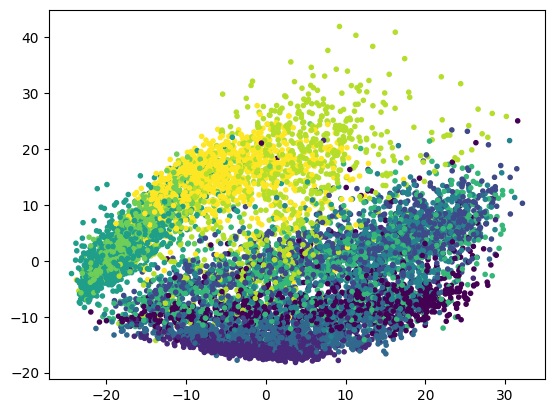

In [9]:
## Perform linear PCA and print its first 2 and 3 components


## Save data to files
if os.path.exists("data_pca_linear.pickle"):
     ## If the file exixts, load it
    data_pca_linear = load_data("data_pca_linear.pickle")
    
else:
    ## If the file does not exixts, create it
    
    model = PCA()
    data_pca_linear = model.fit_transform(train_subset_scaled)
    save_data(data_pca_linear, "data_pca_linear.pickle")
        

plt.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], c = labels_subset, marker='.')

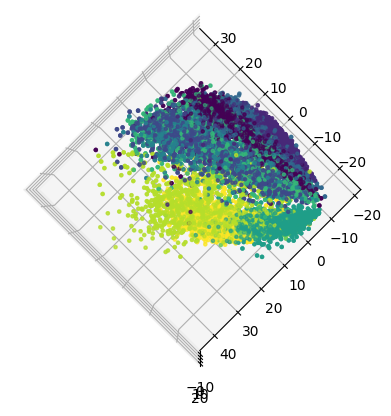

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Color the data points based on the labels
for i in range(3):
    ax.scatter(data_pca_linear[:, 0], data_pca_linear[:, 1], data_pca_linear[:, 2], c = labels_subset, marker='.')

ax.view_init(elev=90, azim=135)

### 1.2: Perform kernel PCA

In [11]:
## Perform kernel pca using the RBF kernel


if os.path.exists("data_pca_rbf.pickle"):
     ## If the file exixts, load it
    data_pca_rbf = load_data("data_pca_rbf.pickle")
    
else:
    ## If the file does not exixts, create it
    
    kernel_pca = KernelPCA(kernel="rbf", n_components = 3)
    data_pca_rbf = kernel_pca.fit_transform(train_subset_scaled)
    
    save_data(data_pca_rbf, "data_pca_rbf.pickle")

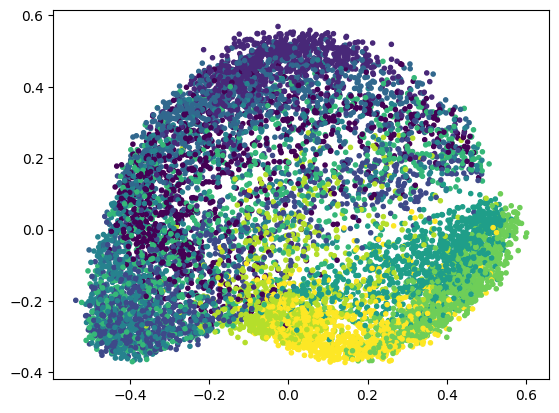

In [12]:
plt.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], c = labels_subset, marker='.')

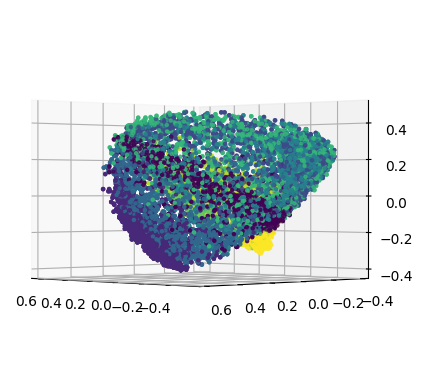

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Color the data points based on the labels
for i in range(3):
    ax.scatter(data_pca_rbf[:, 0], data_pca_rbf[:, 1], data_pca_rbf[:, 2], c = labels_subset, marker='.')

ax.view_init(elev=0, azim=135)

### Perform parameter tuning

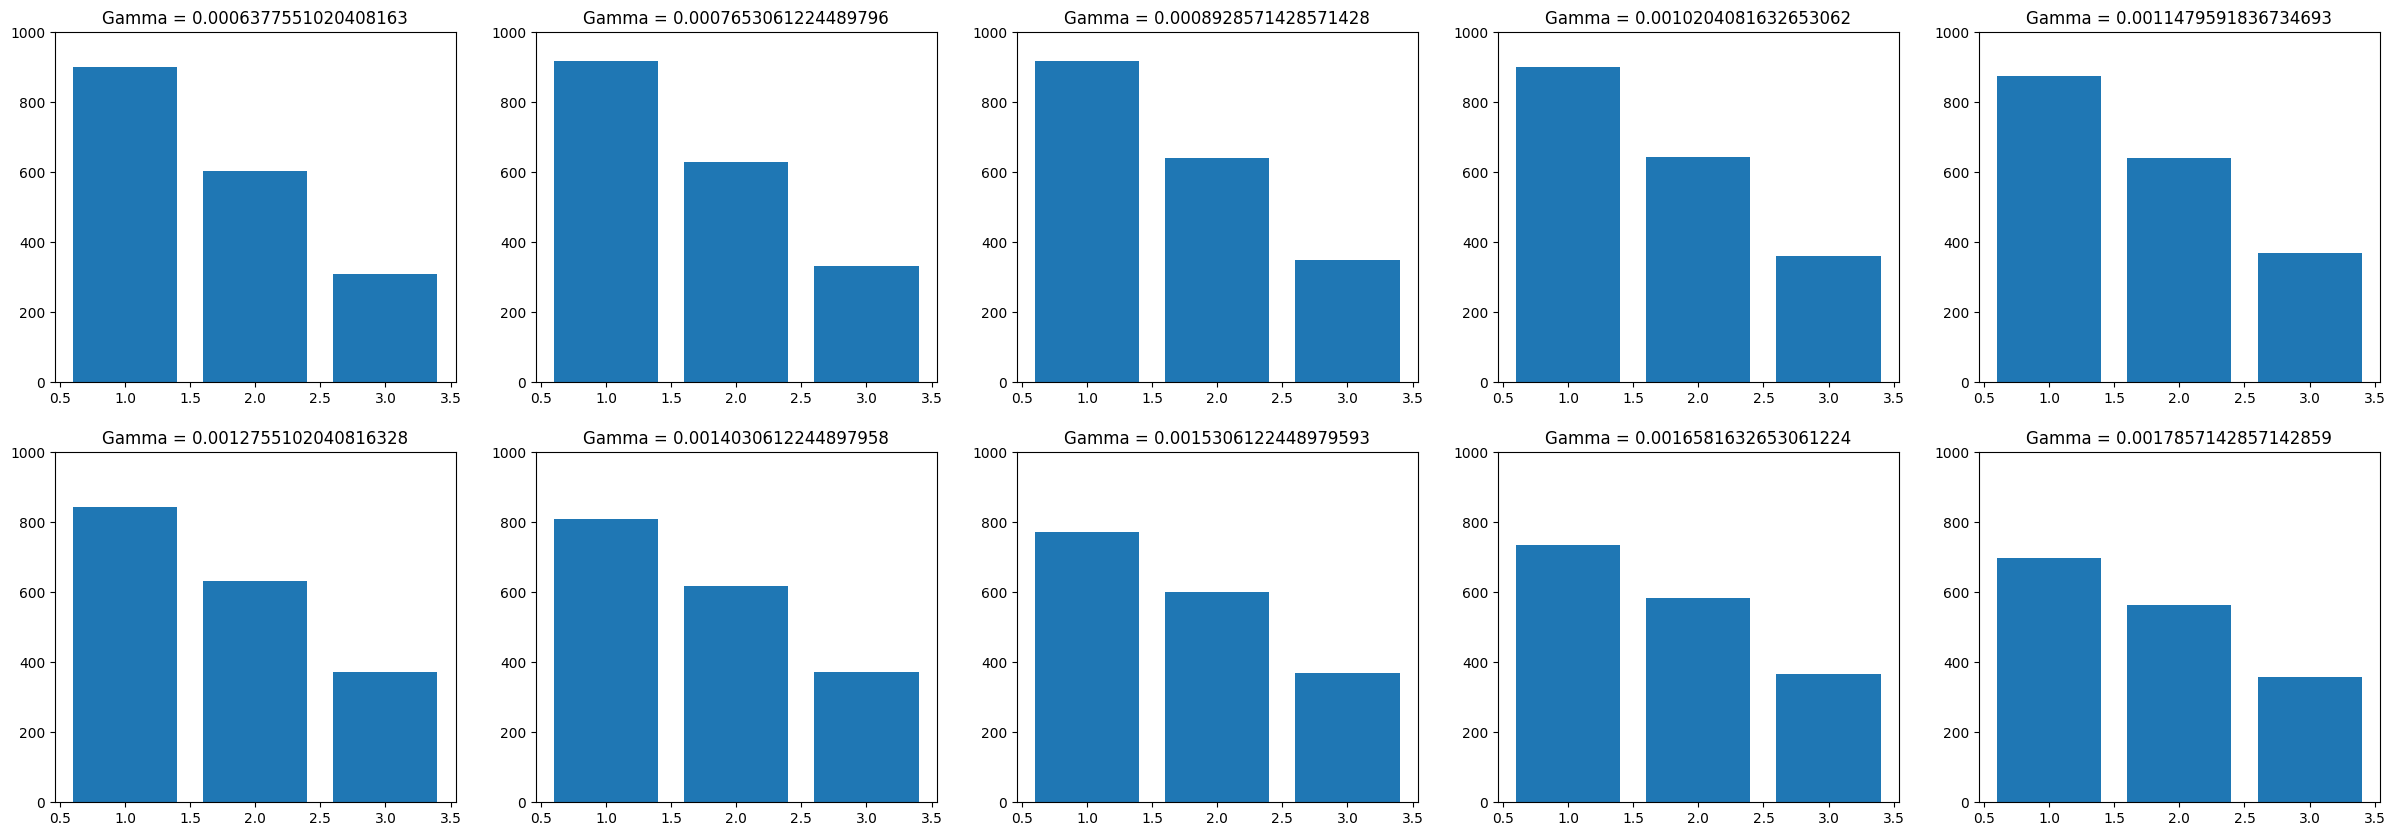

In [14]:
## Choose the range of the parameter gamma
gammas = np.arange(1/784 - 5 * (1/784) * (1/10), 1/784 + 5 * (1/784) * (1/10), (1/784) * (1/10))


if os.path.exists("eigenvalues_rbf.pickle"):
     ## If the file exixts, load it
    eigenvalues_rbf = load_data("eigenvalues_rbf.pickle")
    
else:
    ## If the file does not exixts, create it

    ## Extract eigenvalues
    n_components = 3
    eigenvalues_rbf = np.empty((len(gammas), n_components))

    for i in range(len(gammas)):
        kernel_pca = KernelPCA(kernel="rbf", n_components = n_components, gamma = gammas[i])
        eigenvalues_rbf[i] = kernel_pca.fit(train_subset_scaled).eigenvalues_
        
    save_data(eigenvalues_rbf, "eigenvalues_rbf.pickle")



# Plot the results
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

# Create 10 random plots
for i, ax in enumerate(axs.flat):
    # Generate random data
    x = np.arange(1, len(eigenvalues_rbf[i, :]) + 1, 1)
    # Plot the data on the corresponding axis
    ax.bar(x, eigenvalues_rbf[i, :])
    ax.set_ylim(0, 1000)
    # ax.set_xlabel('Component')
    # ax.set_ylabel('Eigenvalue')
    ax.set_title('Gamma = ' + str(gammas[i]))

### 1.3 Perform kPCA using another kernel

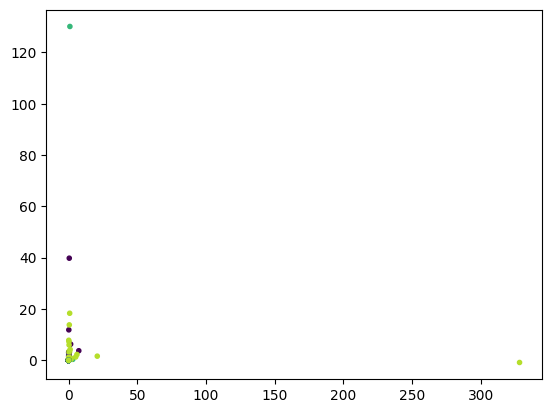

In [15]:
## Try kernel poly

if os.path.exists("data_pca_poly.pickle"):
     ## If the file exixts, load it
    data_pca_poly = load_data("data_pca_poly.pickle")
    
else:
    ## If the file does not exixts, create it
    
    kernel_pca = KernelPCA(kernel="poly", n_components = 3)

    data_pca_poly = kernel_pca.fit_transform(train_subset_scaled)
    
    save_data(data_pca_poly, "data_pca_poly.pickle")
    


plt.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], c = labels_subset, marker='.')

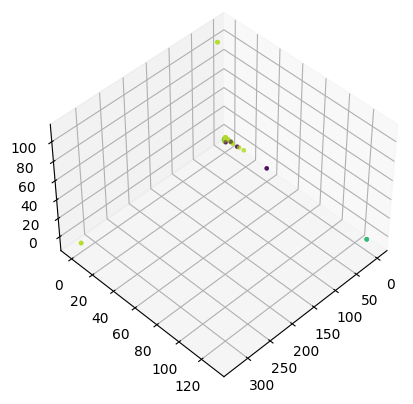

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Color the data points based on the labels
for i in range(3):
    ax.scatter(data_pca_poly[:, 0], data_pca_poly[:, 1], data_pca_poly[:, 2], c = labels_subset, marker='.')

ax.view_init(elev=45, azim=45)

In [17]:
# degs = np.arange(1, 7, 1)

# n_components = 3
# eigenvalues = np.empty((len(degs), n_components))

# for i in range(len(degs)):
#     kernel_pca = KernelPCA(kernel="poly", n_components = n_components, degree = degs[i])
#     eigenvalues[i] = kernel_pca.fit(train_subset_scaled).eigenvalues_

# # Create a figure and axis with 2 rows and 5 columns
# fig, axs = plt.subplots(2, 3, figsize=(30, 10))

# # Create 10 random plots
# for i, ax in enumerate(axs.flat):
#     # Generate random data
#     x = np.arange(1, len(eigenvalues[i, :]) + 1, 1)
#     # Plot the data on the corresponding axis
#     ax.bar(x, eigenvalues[i, :])
#     ax.set_ylim(0, 1000)
#     # ax.set_xlabel('Component')
#     # ax.set_ylabel('Eigenvalue')
#     ax.set_title('Degree = ' + str(degs[i]))

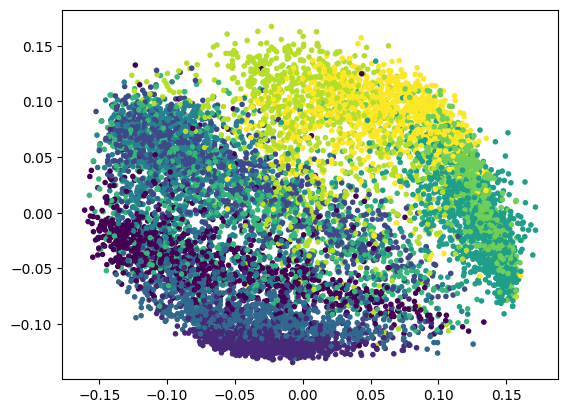

In [19]:
## Try kernel sigmoid

if os.path.exists("data_pca_sigmoid.pickle") and os.path.exists("eigenvalues_sigmoid.pickle"):
    
     ## If the file exixts, load it
    data_pca_sigmoid = load_data("data_pca_sigmoid.pickle")
    eigenvalues_sigmoid = load_data("eigenvalues_sigmoid.pickle")
    
else:
    ## If the file does not exixts, create it
    
    kernel_pca = KernelPCA(kernel="sigmoid", n_components = 10)

    data_pca_sigmoid = kernel_pca.fit_transform(train_subset_scaled)
    
    save_data(data_pca_sigmoid, "data_pca_sigmoid.pickle")
    
    eigenvalues_sigmoid = kernel_pca.eigenvalues_
    
    save_data(eigenvalues_sigmoid, "eigenvalues_sigmoid.pickle")

plt.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels_subset, marker='.')

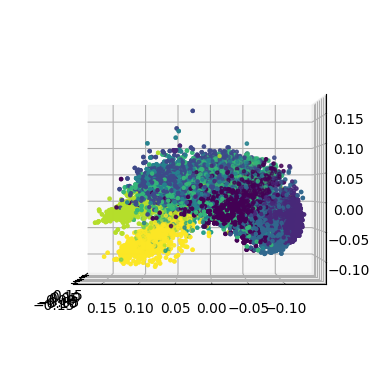

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Color the data points based on the labels
for i in range(3):
    ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], data_pca_sigmoid[:, 2], c = labels_subset, marker='.')

ax.view_init(elev=0, azim=180)

## Section 2

### 2.1

In [21]:
# # Clustering

# if os.path.exists("kernel_pca.pickle"):
#      ## If the file exixts, load it
#     kernel_pca = load_data("data_pca_sigmoid.pickle")

# else: 
#     kernel_pca = KernelPCA(kernel="sigmoid", n_components = 10).fit(train_subset_scaled)
#     save_data(kernel_pca, "kernel_pca.pickle")


# data_pca_sigmoid = kernel_pca.transform(train_subset_scaled)


In [22]:
labels_Kmeans = KMeans(n_clusters = 10).fit(data_pca_sigmoid).labels_

labels_Spectral = SpectralClustering(n_clusters = 10, affinity='nearest_neighbors').fit(data_pca_sigmoid).labels_

labels_Gaussian = GaussianMixture(n_components = 10).fit(data_pca_sigmoid).predict(data_pca_sigmoid)

labels = np.array([labels_subset.reshape(subset_size), labels_Kmeans, labels_Spectral, labels_Gaussian])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


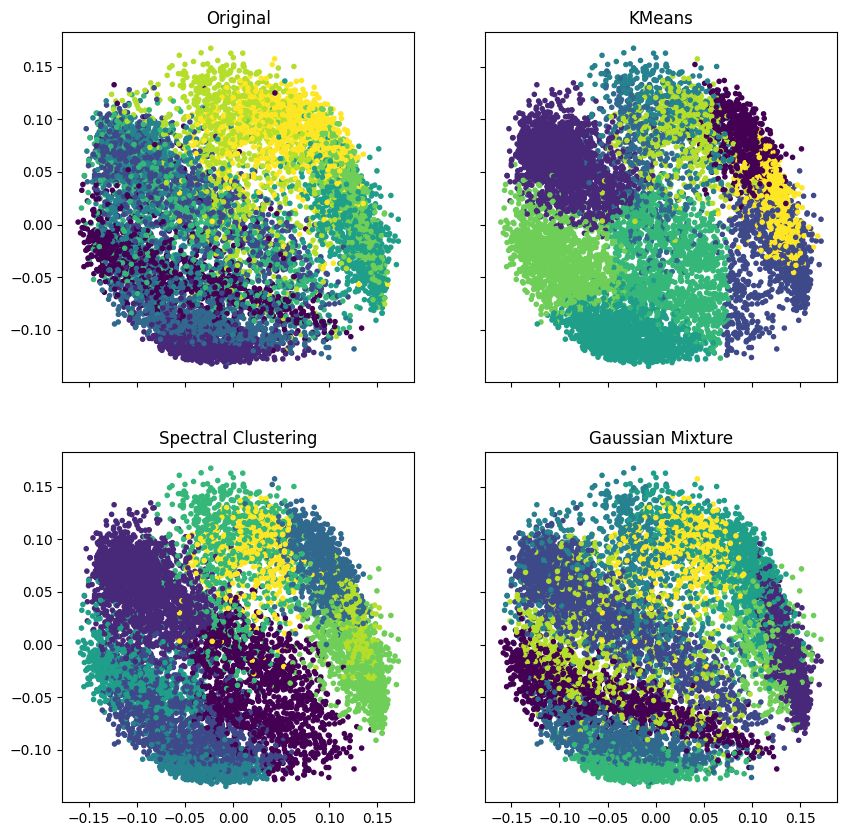

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

title_names = ["Original", "KMeans", "Spectral Clustering", "Gaussian Mixture"]

for ax, i in zip(axs.flat, range(4)):
    ax.scatter(data_pca_sigmoid[:, 0], data_pca_sigmoid[:, 1], c = labels[i, :], marker='.')
    ax.set_title(title_names[i])

In [24]:
## Adjusted Rand Index

ARI = np.empty(3)

for i in range(3):
    ARI[i] = adjusted_rand_score(labels[0, :], labels[i + 1, :])
    print("Adjusted Rand Index for " + title_names[i + 1] + ": " + str(ARI[i]))

Adjusted Rand Index for KMeans: 0.36275887788773237
Adjusted Rand Index for Spectral Clustering: 0.43403992188941926
Adjusted Rand Index for Gaussian Mixture: 0.4046095192543068


#### a
As we can see, label assignment performed poorly. This, probably, because the clusters are very close to each other and not clearly separated.

#### b
As we can see from the plot below, there is a clear elbow on the third component. This suggests that 10 does not reflect the actual knee point of the spectrum of the principal components.

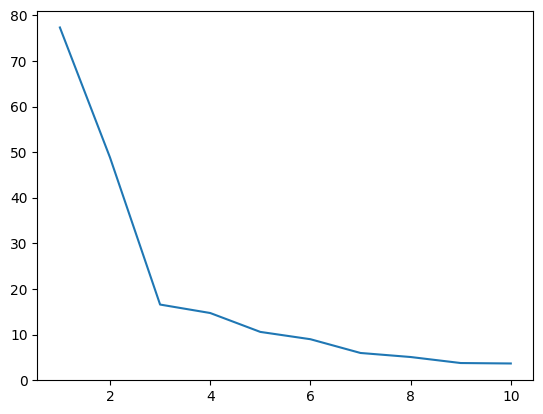

In [25]:
plt.plot(np.arange(1, len(eigenvalues_sigmoid) + 1, 1), eigenvalues_sigmoid)

### 3: Supervised Classification



In [26]:
subset_size = 64

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)]),
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)]),
    download=True
)

train_loader = DataLoader(dataset = train_dataset, shuffle=True, batch_size=subset_size)
test_loader = DataLoader(dataset = test_dataset, shuffle=True, batch_size=subset_size)

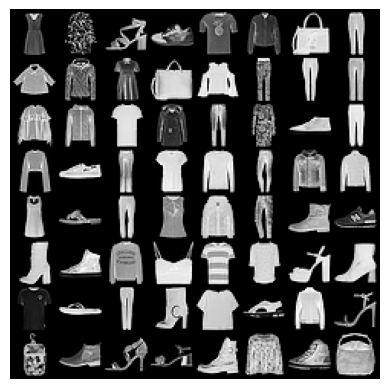

In [27]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images))

In [28]:
## Define functions for hinge loss

def hinge_loss(y_true, y_pred):
    
    temp_vec = []
    
    for i in range(len(y_true)):
        temp_vec.append(max(0, 1 - y_true[i] * y_pred[i]))
        
    return sum(temp_vec)

In [34]:
# Some useful functions
def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        test_acc += get_batch_accuracy(outputs, labels)
        return test_loss, test_acc
    
def hinge_loss(y_pred, y_true):
    return th.mean(th.clamp(1 - y_pred.t() * y_true, min=0))

#### 3.1

In [30]:
# subset_size = 64

# train_dataset = datasets.FashionMNIST(
#     root="./data",
#     train=True,
#     transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)]),
#     download=True
# )

# test_dataset = datasets.FashionMNIST(
#     root="./data",
#     train=False,
#     transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=0, std=1)]),
#     download=True
# )

# train_loader = DataLoader(dataset = train_dataset, shuffle=True, batch_size=subset_size)
# test_loader = DataLoader(dataset = test_dataset, shuffle=True, batch_size=subset_size)

# class KernelSVM(nn.Module):
#     def __init__(self, n_classes, image_size, kernel_type, gamma_init):
#         super(KernelSVM, self).__init__()
#         assert kernel_type in ["linear", "rbf"]
        
#         if kernel_type == 'linear':
#             self._kernel = self.linear
#             self.bias = nn.Parameter(th.zeros(1, n_classes))
#             self.support_vectors = nn.Parameter(th.randn(image_size, 1))
#             self._n_classes = n_classes
            
#         elif kernel_type == 'rbf':
#             self._kernel = self.rbf
#             self._n_classes = x.size(0)
#             self.gamma = nn.Parameter(th.FloatTensor([gamma_init]))
            
#         else:
#             assert False, "Kernel type not supported"
        
#         self._w = nn.Linear(in_features = image_size, out_features = n_classes)
    
    
#     def linear(self, x):
#         return th.mm(x, self.support_vectors)
            
#     # def rbf(self, x):
#     #     x_prime = x.repeat(1, 1, 1)
        
#     #     # p = 2 => Euclidean distance
#     #     y = th.exp(-self.gamma * th.norm(x - x_prime, p = 2)**2)
#     #     return x
            
        
#     def forward(self, x):
#         x = x.flatten(start_dim = 1)
#         x = self._kernel(x)
#         x = F.log_softmax(x, dim = 1)
#         # y = self._w(y)
#         return x

# model = KernelSVM(n_classes = 10, image_size = 28 * 28, kernel_type='linear', gamma_init=1)

# device = th.device("cuda" if th.cuda.is_available() else "cpu")
# model = model.to(device)
# print(f"Using device: {device}")

# # for _, (images, labels) in enumerate(test_loader):
# #     print(images.shape)
# #     images = images.to(device)
# #     output = model(images)
# #     break

# # output.shape

# criterion = nn.NLLLoss()

# optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

# model = model.eval()

# untrained_loss, untrained_acc = get_test_stats(model, criterion, test_loader, device)

# model = model.train()

# print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

In [47]:
class LinearSVM(nn.Module):
    def __init__(self, n_classes, image_size):
        super(LinearSVM, self).__init__()

        
        self.bias = nn.Parameter(th.zeros(1, n_classes), requires_grad = True)
        self.w = nn.Parameter(th.randn(image_size, 1), requires_grad = True)
            
        
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        y = x.matmul(self.w)
        y = F.log_softmax(y, dim = 1)
        return y + self.bias


model = LinearSVM(n_classes = 10, image_size = 28 * 28)

device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

criterion = hinge_loss

optimizer = th.optim.SGD(model.parameters(), lr=0.1, momentum=0)


model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, test_loader, device)

model = model.train()

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

Using device: cpu
Untrained test loss: 1.0000, accuracy: 12.50%


In [50]:
EPOCHS = 3

batch_losses = []

for epoch in trange(EPOCHS):
    model = model.train()

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        batch_losses.append(loss.item())  # Store the loss for plotting, per batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:58<00:00, 11.75s/it]


In [51]:
# Get test stats after training
trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)

print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

Accuracy: 12.5 | Loss: 0.125


In [ ]:
# class KernelSVM(nn.Module):
#     def __init__(self, n_classes, image_size):
#         super(KernelSVM, self).__init__()
#         # self.kernel = kernel_type
#         self._w = nn.Linear(in_features = image_size, out_features = n_classes)
        
#     def forward(self, x):
#         x = x.flatten(start_dim = 1)
#         x = self._w(x)
#         return x
    
#         # x = F.log_softmax(x, dim = 1)

In [ ]:
class Sigmoid_SVM(nn.Module):
    def __init__(self, n_classes, image_size, alpha_init):
        super(Sigmoid_SVM, self).__init__()
        self.alpha = nn.Parameter(th.FloatTensor([alpha_init]))
            
        
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        
        y = np.tanh() 


model = Sigmoid_SVM(n_classes = 10, image_size = 28 * 28)

device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# for _, (images, labels) in enumerate(test_loader):
#     print(images.shape)
#     images = images.to(device)
#     output = model(images)
#     break

# output.shape

criterion = nn.NLLLoss()

optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, test_loader, device)

model = model.train()

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

#### 3.2: Fully Connected NN

In [52]:
class FullyConnectedNN(nn.Module):
    def __init__(self, image_dim, n_classes):
        
        super(FullyConnectedNN, self).__init__()
        
        self.fc = nn.Linear(in_features = image_dim,
                            out_features = n_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = self.fc(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [107]:
model = FullyConnectedNN(image_dim = 28 * 28, n_classes = 10)

# Device selection
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

criterion = nn.NLLLoss()

optimizer = th.optim.SGD(model.parameters(), lr=0.01, momentum=0)

Using device: cpu


In [108]:
model(images).shape

torch.Size([32, 10])

In [54]:
model = model.eval()

untrained_loss, untrained_acc = get_test_stats(model, criterion, train_loader, device)

model = model.train()

print(f"Untrained test loss: {untrained_loss:.4f}, accuracy: {untrained_acc:.2f}%")

Untrained test loss: 2.3464, accuracy: 9.38%


In [55]:
batch_losses = []

for epoch in trange(EPOCHS):
    model = model.train()

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        batch_losses.append(loss.item())  # Store the loss for plotting, per batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

100%|██████████| 5/5 [01:18<00:00, 15.68s/it]


In [56]:
# Get test stats after training
trained_loss, trained_acc = get_test_stats(model, criterion, test_loader, device)

print(f"Accuracy: {trained_acc} | Loss: {trained_loss}")

Accuracy: 84.375 | Loss: 0.4684932827949524


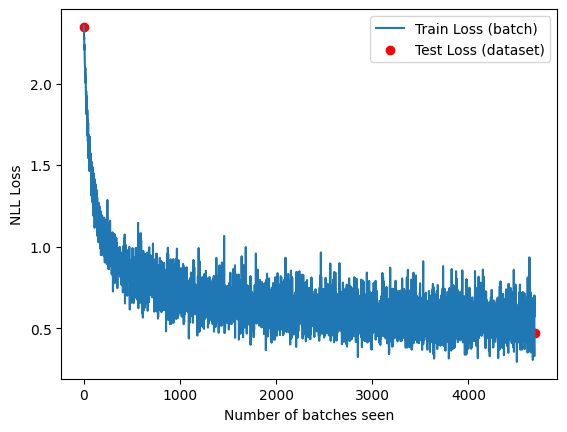

In [57]:
# Plot losses
xrange = range(len(batch_losses))
_ = plt.plot(xrange, batch_losses)
_ = plt.scatter((xrange[0], xrange[-1]), (untrained_loss, trained_loss), color="red")
_ = plt.legend(["Train Loss (batch)", "Test Loss (dataset)"], loc="upper right")
_ = plt.xlabel("Number of batches seen")
_ = plt.ylabel("NLL Loss")

#### 3.2: Convolutional NN

In [65]:
# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    th.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with th.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = th.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

def train(num_epochs, loss_fn, optimizer, model):
    
    best_accuracy = 0.0

    # Define your execution device
    device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = th.autograd.Variable(images.to(device))
            labels = th.autograd.Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [102]:
images.shape

print(images.shape)

conv_layer = nn.Conv2d(in_channels = 1, out_channels = 12, kernel_size = 1)

out = conv_layer(images)

print(out.shape)

bn1 = nn.BatchNorm2d(num_features=12)

out = bn1(out)

print(out.shape)

out = F.relu(out)

print(out.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 12, 28, 28])
torch.Size([32, 12, 28, 28])
torch.Size([32, 12, 28, 28])


In [109]:
class CNN(nn.Module):
    def __init__(self, n_classes, feature_num, k_size):
        super(CNN, self).__init__()
        
        self._n_classes = n_classes
        self._feature_num = feature_num
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = feature_num, kernel_size=k_size, stride=1, padding=1)
        print("Defined conv1")
        self.bn1 = nn.BatchNorm2d(feature_num)
        print("Defined bn1")
        
        self.conv2 = nn.Conv2d(in_channels = feature_num, out_channels = feature_num, kernel_size=k_size, stride=1, padding=1)
        print("Defined conv2")
        self.bn2 = nn.BatchNorm2d(feature_num)
        print("Defined bn2")
        
        self.pool = nn.MaxPool2d(2,2)
        print("Defined pool")
        
        self.conv4 = nn.Conv2d(in_channels=feature_num, out_channels=2 * feature_num, kernel_size=k_size, stride=1, padding=1)
        print("Defined conv4")
        self.bn4 = nn.BatchNorm2d(2 * feature_num)
        print("Defined bn4")
        
        self.conv5 = nn.Conv2d(in_channels= 2 * feature_num, out_channels=2 * feature_num, kernel_size= k_size, stride=1, padding=1)
        print("Defined conv5")
        self.bn5 = nn.BatchNorm2d(2 * feature_num)
        print("Defined bn5")
        self.fc1 = nn.Linear(2 * feature_num * n_classes * n_classes, n_classes)
        print("Defined fc1")
        
    def forward(self, input):
        # in: 32 x 1 x 28 x 28
        output = self.conv1(input)
        # out: 32 x 12 x 28 x 28
        print("Applied conv1") 
        
        # in: 32 x 12 x 28 x 28
        output = self.bn1(output)
        # out: 32 x 12 x 28 x 28
        print("Applied bn1")
        
        # in: 32 x 12 x 28 x 28 
        output = F.relu(output)
        # out: 32 x 12 x 28 x 28
        print("Applied relu 1")
        
        # output = self.conv2(output)
        # print("Applied conv2")
        # output = self.bn2(output)
        # print("Applied bn1")
        # output = F.relu(output)
        # print("Applied relu 2")
        
        # output = self.pool(output)    
        # print("Applied pool")   
        
        # output = self.conv4(output)
        # print("Applied conv4")
        # output = self.bn4(output)
        # print("Applied bn4")
        # output = F.relu(output)   
        # print("Applied relu 4")
        
        # output = F.relu(self.bn5(self.conv5(output)))
        # print("Applied bn5")    
        output = output.view(-1, 32 * self._n_classes * self._n_classes)
        print("Applied view") 
        output = self.fc1(output)
        print("Applied fc1") 
        
        
        return output
    
model = CNN(n_classes = 10, feature_num = 64, k_size = 1)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)

model(images).shape


# train(num_epochs=2, loss_fn=loss_fn, optimizer=optimizer, model=model)


Defined conv1
Defined bn1
Defined conv2
Defined bn2
Defined pool
Defined conv4
Defined bn4
Defined conv5
Defined bn5
Defined fc1
Applied conv1
Applied bn1
Applied relu 1
Applied view


RuntimeError: mat1 and mat2 shapes cannot be multiplied (576x3200 and 12800x10)